In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pathlib import Path
import networkx as nx
import pickle
import re
from IPython.display import display
from tqdm import tqdm
from skimage import io
import scipy as sp
import os
from scipy.ndimage import distance_transform_edt
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.loader import DataLoader
from IPython.display import clear_output
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import torch_geometric.transforms as T
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import rand_score
from sklearn.metrics import classification_report
#import pytorchgeometric as ptg

In [2]:
import numpy as np
from pathlib import Path
import re
import networkx as nx
import pickle
from skimage import io
from torch_geometric.utils.convert import from_networkx
from torch_geometric.loader import DataLoader
from tqdm import tqdm 
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphUNet, GAT, GCN
from scipy.ndimage import distance_transform_edt
from os.path import exists

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    #z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    z = h.detach().numpy()
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.legend()
    plt.show()

In [3]:
folder = Path('/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_preds_graphs_fwhm_single_excel')
files = list(folder.glob('*_warped_radii_amended_AVC.pickle'))
files = sorted([x.as_posix() for x in files])
print(files[0])
len(files)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#io.imread(files).shape

/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_preds_graphs_fwhm_single_excel/vbm03 Feb 26 2020-XYZres007_0001_warped_radii_amended_AVC.pickle


In [4]:
#folder = Path('/home/rozakmat/projects/rrg-bojana/rozakmat/')
#files = list(folder.glob('*/*/*vbm03 Feb 26 2020-XYZres007_0001_warped_mean.npy'))
#files = sorted([x.as_posix() for x in files])

#len(files)
#files
#io.imread(files).shape

In [5]:
#re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single_upsampled',re.sub('_radii_amended_AVC.pickle','_mean.npy',file))

In [6]:
for file in files:
    with open(file, 'rb') as f:
        graph = pickle.load(f)
    res = []
    for edge in graph.edges:
        path = graph[edge[0]][edge[1]]['pts']
        res.append(np.max(path,axis=0))
    break
    #print(np.max(np.array(res),axis=0))

Dont use LSTM
Subdivide features and 

In [51]:
subjects = list(Path('/home/rozakmat/projects/rrg-bojana/rozakmat/James_VBM/datasets').glob('*'))
subjects = sorted([x.as_posix() for x in subjects])
np.random.seed(12)
np.random.shuffle(subjects)
train_subj = subjects[:4]
test_subj = subjects[4:6]
val_subj = subjects[6:]
train_imgs = list(np.concatenate([list(Path(x).glob('*.oir')) for x in train_subj]).flat)
train_imgs = np.unique(sorted([re.sub('_0001','',re.sub('.oir','',x.name)) for x in train_imgs]))
train_pickles = [x for x in files if any(y in x for y in train_imgs)]

test_imgs = list(np.concatenate([list(Path(x).glob('*.oir')) for x in test_subj]).flat)
test_imgs = np.unique(sorted([re.sub('_0001','',re.sub('.oir','',x.name)) for x in test_imgs]))
test_pickles = [x for x in files if any(y in x for y in test_imgs)]

val_imgs = list(np.concatenate([list(Path(x).glob('*.oir')) for x in val_subj]).flat)
val_imgs = np.unique(sorted([re.sub('_0001','',re.sub('.oir','',x.name)) for x in val_imgs]))
val_pickles = [x for x in files if any(y in x for y in val_imgs)]

#display(train_pickles)
#display(test_pickles)
display(val_pickles[0])
print(len(files))
data_list = []

for file in tqdm(train_pickles[:]):
    #file = 'James_labelling_AVC/james_preds/XYZres019_warped_single_radii_matched_AVC.pickle'
    with open(file, 'rb') as f:
        G = graph = pickle.load(f)
    tif_img = io.imread(re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single',re.sub('_warped_radii_amended_AVC.pickle','_warped.tif',file))).astype('float32')
    #img_resized = sp.ndimage.zoom(tif_img[:,0],1/(np.array(tif_img[:,0].shape)/np.array([512,507,507])))
    #break
    if os.path.exists(re.sub('_warped_radii_amended_AVC.pickle','_warped_up.tif',file)):
        img_resized = io.imread(re.sub('_warped_radii_amended_AVC.pickle','_warped_up.tif',file)).astype('float32')
    else:
        img_resized = sp.ndimage.zoom(tif_img[:,0],1/(np.array(tif_img[:,0].shape)/np.array([254,512,512])))
        io.imsave(re.sub('_warped_radii_amended_AVC.pickle','_warped_up.tif',file),img_resized)
    if os.path.exists(re.sub('_radii_amended_AVC.pickle','_nrn_dst.tif',file)):
        nrn_dst = io.imread(re.sub('_radii_amended_AVC.pickle','_nrn_dst.tif',file)).astype('float32')
    else:
        nrn_seg = 1 - (np.argmax(np.load(re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single_upsampled',re.sub('_radii_amended_AVC.pickle','_mean.npy',file))),axis=0)==2)*1 #get neuron segmentation for more features
        nrn_dst = distance_transform_edt(nrn_seg) #get image of distance to nearest neuron
        io.imsave(re.sub('_radii_amended_AVC.pickle','_nrn_dst.tif',file),nrn_dst)
    
    for edge in G.edges:
        for keys in G[edge[0]][edge[1]]:
            if type(G[edge[0]][edge[1]][keys]) == str:
                G[edge[0]][edge[1]][keys] = 0
        path = graph[edge[0]][edge[1]]['pts']
        path_smooth = np.float32(np.copy(path))  
        for k in range(len(path[0])):
            path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
        path_grad = np.gradient(path_smooth,edge_order=2)[0]
        path_grad = normalize(path_grad,axis=1)
        #if G[edge[0]][edge[1]]['start_depth'] == 0 or G[edge[0]][edge[1]]['start_depth'] == 
        G[edge[0]][edge[1]]['x'] = np.array([G[edge[0]][edge[1]]['weight'],
                                             G[edge[0]][edge[1]]['euclidean-dst'], #euclidean distance
                                             G[edge[0]][edge[1]]['euclidean-dst'] / G[edge[0]][edge[1]]['weight'], #Tortuosity
                                             G[edge[0]][edge[1]]['radii'],
                                             G[edge[0]][edge[1]]['radii_std'],
                                             ###G[edge[0]][edge[1]]['delta'],
                                             ###G[edge[0]][edge[1]]['vessel_type'],
                                             ###G[edge[0]][edge[1]]['vessel_type_std'],
                                             G[edge[0]][edge[1]]['end-0z'],
                                             G[edge[0]][edge[1]]['end-1z'],
                                             np.std(path[:,2]),
                                             np.std(path[:,1]),
                                             np.std(path[:,0]),
                                             np.mean(path_grad[:,0]),
                                             np.mean(path_grad[:,1]),
                                             np.mean(path_grad[:,2]),
                                             np.std(path_grad[:,0]),
                                             np.std(path_grad[:,1]),
                                             np.std(path_grad[:,2]),
                                             #path_grad[:,0].astype(np.float16),
                                             #path_grad[:,1].astype(np.float16),
                                             #path_grad[:,2].astype(np.float16),
                                             #np.array(G[edge[0]][edge[1]]['path_weights']).astype(np.float16)/100,
                                             #img_resized[path[:,2],path[:,1],path[:,0]].astype(np.float16)/1024,
                                             #abs(G[edge[0]][edge[1]]['start_depth'] - path[:,2])
                                             #np.mean(), # AVG intensity vasc at centerline
                                             #np.std(img_resized[path[:,2],path[:,1],path[:,0]]), # STD intensity vasc at centerline
                                             #np.mean(nrn_dst[path[:,0],path[:,1],path[:,2]]), # AVG distance to neuron from centerline
                                             #np.std(nrn_dst[path[:,0],path[:,1],path[:,2]]).astype('float32') # STD distance to neuron from centerline
                                             ])
        G[edge[0]][edge[1]]['x'][np.isnan(G[edge[0]][edge[1]]['x'])] = 0
        #G[edge[0]][edge[1]]['x'] = np.pad(G[edge[0]][edge[1]]['x'],(0,1000-len(G[edge[0]][edge[1]]['x'][0])), 'constant')[0:4]
        G[edge[0]][edge[1]]['x'] = G[edge[0]][edge[1]]['x'].T.flatten()
        G[edge[0]][edge[1]]['y'] = G[edge[0]][edge[1]]['A_V_C']
        #print(G[edge[0]][edge[1]]['x'].shape)
    G_line = nx.line_graph(G, create_using=nx.Graph)
    for i in G_line.nodes:
        G_line.nodes[i]['x'] = G[i[0]][i[1]]['x']
        G_line.nodes[i]['y'] = G[i[0]][i[1]]['y']
    data = from_networkx(G_line, group_node_attrs = ['x'])
    data.num_classes = len(np.unique(data.y))
    data_list.append(data)
loader = DataLoader(data_list,batch_size=40, shuffle = True, exclude_keys = ['pts','o','edge_pts','weight','radii','radii_std','vessel_type','vessel_type_std','path_weights','end-0','end-1','radii_0001','radii_0001_std','pts_0001','delta','A_V_C'])
exit
val_data_list = []
for file in tqdm(val_pickles[:]):
    #file = 'James_labelling_AVC/james_preds/XYZres019_warped_single_radii_matched_AVC.pickle'
    with open(file, 'rb') as f:
        G = graph = pickle.load(f)
    tif_img = io.imread(re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single',re.sub('_warped_radii_amended_AVC.pickle','_warped.tif',file))).astype('float32')
    #img_resized = sp.ndimage.zoom(tif_img[:,0],1/(np.array(tif_img[:,0].shape)/np.array([512,507,507])))
    #break
    if os.path.exists(re.sub('_warped_radii_amended_AVC.pickle','_warped_up.tif',file)):
        img_resized = io.imread(re.sub('_warped_radii_amended_AVC.pickle','_warped_up.tif',file)).astype('float32')
    else:
        img_resized = sp.ndimage.zoom(tif_img[:,0],1/(np.array(tif_img[:,0].shape)/np.array([254,512,512])))
        io.imsave(re.sub('_warped_radii_amended_AVC.pickle','_warped_up.tif',file),img_resized)
    if os.path.exists(re.sub('_radii_amended_AVC.pickle','_nrn_dst.tif',file)):
        nrn_dst = io.imread(re.sub('_radii_amended_AVC.pickle','_nrn_dst.tif',file)).astype('float32')
    else:
        nrn_seg = 1 - (np.argmax(np.load(re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single_upsampled',re.sub('_radii_amended_AVC.pickle','_mean.npy',file))),axis=0)==2)*1 #get neuron segmentation for more features
        nrn_dst = distance_transform_edt(nrn_seg) #get image of distance to nearest neuron
        io.imsave(re.sub('_radii_amended_AVC.pickle','_nrn_dst.tif',file),nrn_dst)
    
    for edge in G.edges:
        for keys in G[edge[0]][edge[1]]:
            if type(G[edge[0]][edge[1]][keys]) == str:
                G[edge[0]][edge[1]][keys] = 0
        path = graph[edge[0]][edge[1]]['pts']
        path_smooth = np.float32(np.copy(path))  
        for k in range(len(path[0])):
            path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
        path_grad = np.gradient(path_smooth,edge_order=2)[0]
        path_grad = normalize(path_grad,axis=1)
        #if G[edge[0]][edge[1]]['start_depth'] == 0 or G[edge[0]][edge[1]]['start_depth'] == 
        G[edge[0]][edge[1]]['x'] = np.array([G[edge[0]][edge[1]]['weight'],
                                             G[edge[0]][edge[1]]['euclidean-dst'], #euclidean distance
                                             G[edge[0]][edge[1]]['euclidean-dst'] / G[edge[0]][edge[1]]['weight'], #Tortuosity
                                             G[edge[0]][edge[1]]['radii'],
                                             G[edge[0]][edge[1]]['radii_std'],
                                             ###G[edge[0]][edge[1]]['delta'],
                                             ###G[edge[0]][edge[1]]['vessel_type'],
                                             ###G[edge[0]][edge[1]]['vessel_type_std'],
                                             G[edge[0]][edge[1]]['end-0z'],
                                             G[edge[0]][edge[1]]['end-1z'],
                                             np.std(path[:,2]),
                                             np.std(path[:,1]),
                                             np.std(path[:,0]),
                                             np.mean(path_grad[:,0]),
                                             np.mean(path_grad[:,1]),
                                             np.mean(path_grad[:,2]),
                                             np.std(path_grad[:,0]),
                                             np.std(path_grad[:,1]),
                                             np.std(path_grad[:,2]),
                                             #path_grad[:,0].astype(np.float16),
                                             #path_grad[:,1].astype(np.float16),
                                             #path_grad[:,2].astype(np.float16),
                                             #np.array(G[edge[0]][edge[1]]['path_weights']).astype(np.float16)/100,
                                             #img_resized[path[:,2],path[:,1],path[:,0]].astype(np.float16)/1024,
                                             #abs(G[edge[0]][edge[1]]['start_depth'] - path[:,2])
                                             #np.mean(), # AVG intensity vasc at centerline
                                             #np.std(img_resized[path[:,2],path[:,1],path[:,0]]), # STD intensity vasc at centerline
                                             #np.mean(nrn_dst[path[:,0],path[:,1],path[:,2]]), # AVG distance to neuron from centerline
                                             #np.std(nrn_dst[path[:,0],path[:,1],path[:,2]]).astype('float32') # STD distance to neuron from centerline
                                             ])
        G[edge[0]][edge[1]]['x'][np.isnan(G[edge[0]][edge[1]]['x'])] = 0
        #G[edge[0]][edge[1]]['x'] = np.pad(G[edge[0]][edge[1]]['x'],(0,1000-len(G[edge[0]][edge[1]]['x'][0])), 'constant')[0:4]
        G[edge[0]][edge[1]]['x'] = G[edge[0]][edge[1]]['x'].T.flatten()
        G[edge[0]][edge[1]]['y'] = G[edge[0]][edge[1]]['A_V_C']
        #print(G[edge[0]][edge[1]]['x'].shape)
    G_line = nx.line_graph(G, create_using=nx.Graph)
    for i in G_line.nodes:
        G_line.nodes[i]['x'] = G[i[0]][i[1]]['x']
        G_line.nodes[i]['y'] = G[i[0]][i[1]]['y']
    data = from_networkx(G_line, group_node_attrs = ['x'])
    data.num_classes = len(np.unique(data.y))
    val_data_list.append(data)
val_loader = DataLoader(val_data_list,batch_size=20, shuffle = True, exclude_keys = ['pts','o','edge_pts','weight','radii','radii_std','vessel_type','vessel_type_std','path_weights','end-0','end-1','radii_0001','radii_0001_std','pts_0001','delta','A_V_C'])


'/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_preds_graphs_fwhm_single_excel/vbm07 Mar 24 2020-XYZres021_0001_warped_radii_amended_AVC.pickle'

84


100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


In [52]:
#edge = list(G.edges)[0]
#G[edge[0]][edge[1]]['x'].T

In [53]:
#edge = list(G.edges)[1]
#G[edge[0]][edge[1]]['x'].T

In [54]:
for dataset_val in val_loader:
    dataset_val.num_classes = max(dataset_val.num_classes)
    print(data.num_features)
dataset_val.num_classes = dataset_val.num_classes.tolist()

16


In [55]:
for dataset in loader:
    dataset.num_classes = max(dataset.num_classes)
    print(data.num_features)
dataset.num_classes = dataset.num_classes.tolist()

16


In [56]:
compute_class_weight(class_weight='balanced',classes=np.unique(dataset.y.detach().numpy()),y=dataset.y.detach().numpy())**1.5

array([37.00165697,  6.23724183,  0.23650358])

In [57]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Number of training nodes: {data.train_mask.sum()}')
#print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: DataBatch(edge_index=[2, 71004], y=[20920], x=[20920, 16], num_classes=3, batch=[20920], ptr=[41]):
Number of graphs: 40
Number of features: 16
Number of classes: 3

DataBatch(edge_index=[2, 71004], y=[20920], x=[20920, 16], num_classes=3, batch=[20920], ptr=[41])
Number of nodes: 20920
Number of edges: 71004
Average node degree: 3.39
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [58]:
from torch_geometric.nn import GCNConv
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

#class GCN(torch.nn.Module):
#    def __init__(self, hidden_channels):
#        super().__init__()
#        torch.manual_seed(1234567)
#        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
#        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
#
#    def forward(self, x, edge_index):
#        x = self.conv1(x, edge_index)
#        x = x.relu()
#        x = F.dropout(x, p=0.5, training=self.training)
#        x = self.conv2(x, edge_index)
#        return x

model = GCN(in_channels = -1,
            hidden_channels=8,
            out_channels = 3,
            num_layers = 20,
            dropout = 0.1,
            jk = 'lstm')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
#model = GCN(16)
print(model)

GCN(-1, 3, num_layers=20)


In [59]:
dataset_val.edge_index

tensor([[    0,     0,     1,  ..., 13663, 13663, 13663],
        [  336,   526,    20,  ..., 13581, 13250, 13251]])

In [60]:
dataset_val.x.type(torch.float32)

tensor([[9.6771e+01, 6.0166e+01, 6.2174e-01,  ..., 4.8673e-01, 3.2407e-01,
         3.1531e-01],
        [8.8118e+01, 6.6491e+01, 7.5456e-01,  ..., 2.0556e-01, 2.8284e-01,
         2.9759e-01],
        [3.5024e+01, 2.6230e+01, 7.4891e-01,  ..., 2.8379e-01, 2.3526e-01,
         3.4350e-01],
        ...,
        [4.4195e+01, 3.7175e+01, 8.4117e-01,  ..., 1.3283e-01, 8.2307e-02,
         7.9100e-02],
        [4.5169e+01, 3.8184e+01, 8.4535e-01,  ..., 1.2565e-01, 1.2113e-01,
         1.3155e-01],
        [7.5923e+01, 6.2137e+01, 8.1842e-01,  ..., 3.8170e-01, 1.4599e-01,
         1.6928e-01]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


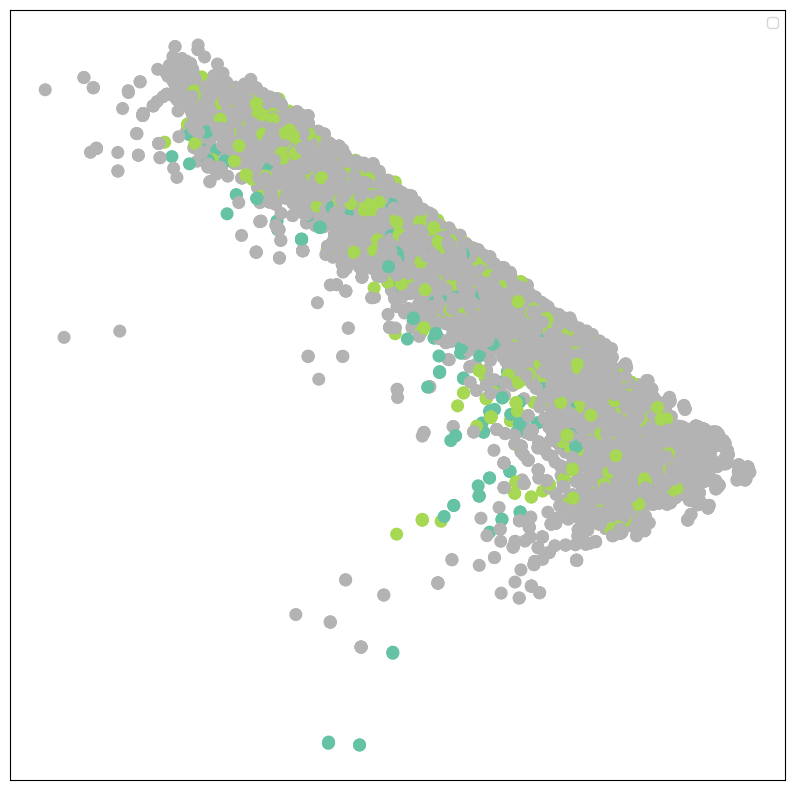

GCN(-1, 3, num_layers=20)

In [61]:
model.eval()
out = model(dataset.x.type(torch.float32), dataset.edge_index.to(device))
visualize(out, color=dataset.y)
model.train()

In [62]:
#from torch_geometric.datasets import CoraFull
#import grafog.transforms as T
#
#node_aug = T.Compose([
#    T.NodeDrop(p=0.05),
#])
#
#edge_aug = T.Compose([
#    T.EdgeDrop(p=0.05),
#])
#

''

  0%|          | 9/5000 [00:09<1:17:51,  1.07it/s]/lustre06/project/6030665/rozakmat/torch_geom/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre06/project/6030665/rozakmat/torch_geom/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre06/project/6030665/rozakmat/torch_geom/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

KeyboardInterrupt: 

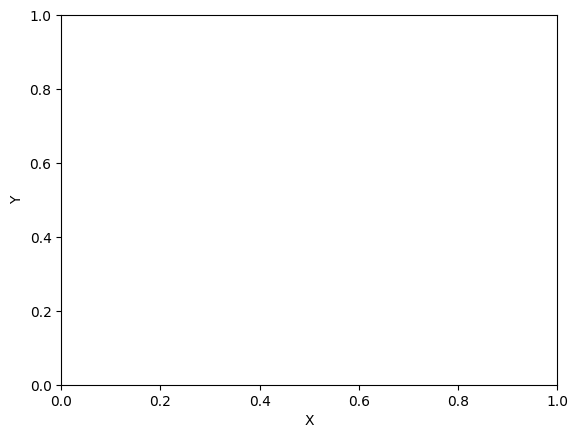

In [63]:
from IPython import display

def pltsin(ax, h, color, hdisplay, colors=['b']):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())
    ax.cla()
    ax.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    hdisplay.update(fig)
    
fig,ax = plt.subplots(1,1)
hdisplay = display.display("", display_id=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

criterion = torch.nn.CrossEntropyLoss(weight = torch.tensor(compute_class_weight(class_weight='balanced',classes=np.unique(dataset_val.y.detach().numpy()),y=dataset_val.y.detach().numpy())).type(torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
def train(loader):
    loss_end = 0
    for dataset in loader:
        dataset = dataset
        optimizer.zero_grad()
        out = model(dataset.x.type(torch.float32), dataset.edge_index)
        loss = criterion(out, dataset.y.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        loss_end += loss
    return loss_end, out
epochs = range(1, 5001)
losses = []
embeddings = []
randScore = []
loss_old = 0
counter = 0
class_report = []
for epoch in tqdm(epochs):
    loss, h = train(loader)
    losses.append(loss.detach().numpy())
    #embeddings.append(h)
    if loss > loss_old:
        counter += 1
    else:
        counter = 0
    loss_old = loss
    if counter > 100:
        break
    if epoch%5000 == 0:
        model.eval()
        out = model(dataset_val.x.type(torch.float32), dataset_val.edge_index)
        pltsin(ax, out, color=dataset_val.y, hdisplay = hdisplay)
        randScore.append(rand_score(dataset_val.y.detach().numpy(),np.argmax(out.detach().numpy(),axis=1)))
        model.train()

    if epoch%10==0:
        model.eval()
        dataset_val = dataset_val.sort(sort_by_row=False)
        out = model(dataset_val.x.type(torch.float32), dataset_val.edge_index)
        randScore.append(rand_score(dataset_val.y.detach().numpy(),np.argmax(out.detach().numpy(),axis=1)))
        class_report.append(classification_report(dataset_val.y.detach().numpy(),np.argmax(out.detach().numpy(),axis=1)))
        model.train()
plt.close(fig)

In [ ]:
out



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


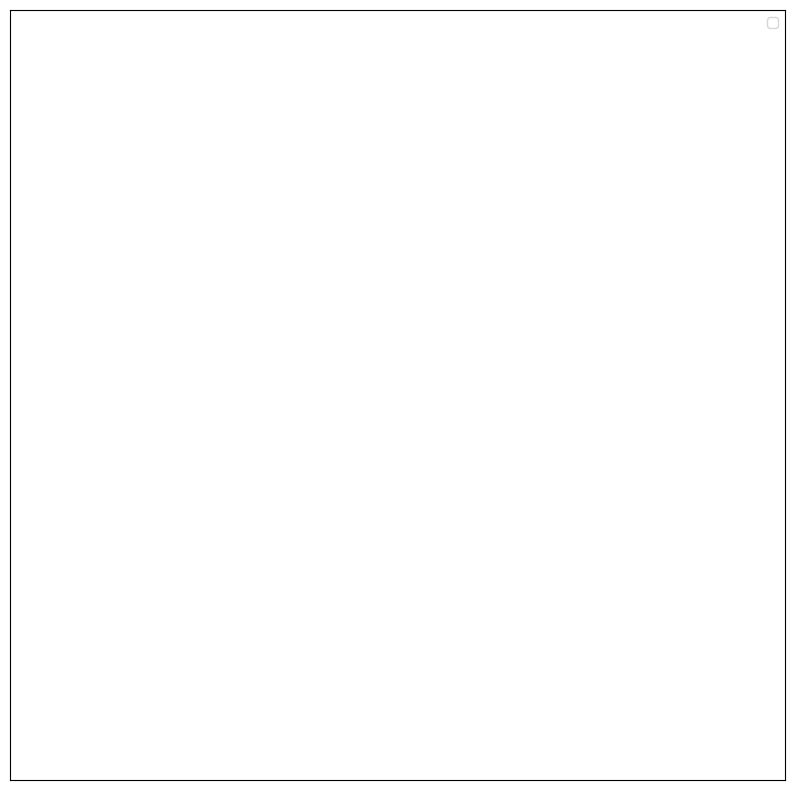

GCN(-1, 3, num_layers=20)

In [64]:
model.eval()
out = model(dataset.x.type(torch.float32), dataset.edge_index.to(device))
visualize(out, color=dataset.y)
model.train()

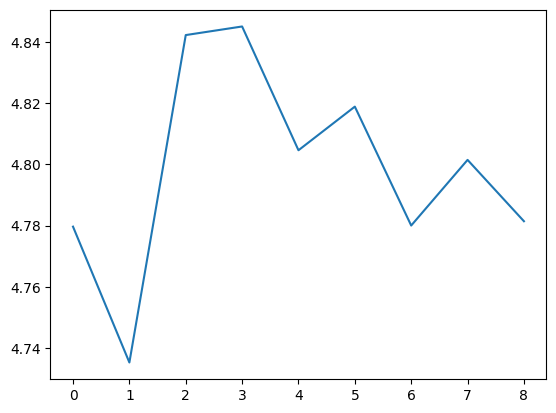

In [65]:
plt.plot(losses)

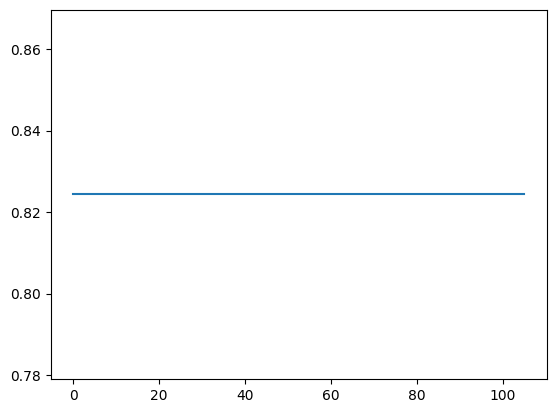

In [66]:
plt.plot(randScore)

In [30]:
dataset_val.y.detach().numpy()

array([2., 2., 2., ..., 2., 2., 2.])

In [31]:
np.argmax(out.cpu().detach().numpy(),axis=1)

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
print(classification_report(dataset_val.y.detach().numpy(),np.argmax(out.cpu().detach().numpy(),axis=1)))

              precision    recall  f1-score   support

         0.0       0.02      0.02      0.02       604
         1.0       0.06      0.81      0.11       688
         2.0       0.95      0.23      0.37     12372

    accuracy                           0.25     13664
   macro avg       0.34      0.35      0.16     13664
weighted avg       0.86      0.25      0.34     13664



In [97]:
np.unique(np.argmax(out.detach().numpy(),axis=1),return_counts=True)

(array([0, 1, 2]), array([ 1498,  4501, 14921]))

Recurrant autoencoder

In [14]:
files = list(Path('GCN_metrics').glob('*_classRepo.npy'))
files = sorted(files)

In [13]:
os.remove(file.as_posix())

FileNotFoundError: [Errno 2] No such file or directory: 'GCN_metrics/GAT13_classRepo.npy'

In [15]:
for file in files[::-1]:
    _tmp = np.load(file)
    print(_tmp[-1])
#plt.ylim(0,2)

              precision    recall  f1-score   support

         0.0       0.10      0.01      0.02       604
         1.0       0.31      0.30      0.30       688
         2.0       0.93      0.97      0.95     12372

    accuracy                           0.90     13664
   macro avg       0.45      0.43      0.42     13664
weighted avg       0.86      0.90      0.88     13664

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       604
         1.0       0.00      0.00      0.00       688
         2.0       0.91      1.00      0.95     12372

    accuracy                           0.91     13664
   macro avg       0.30      0.33      0.32     13664
weighted avg       0.82      0.91      0.86     13664

              precision    recall  f1-score   support

         0.0       0.21      0.06      0.09       604
         1.0       0.22      0.32      0.26       688
         2.0       0.94      0.94      0.94     12372

    accuracy        